# Predicting Optimal Machine Maintenance Cycle

By D. Akman

## Table of Contents
* [Introduction and Overview](#intro) 
* [Exploratory Data Anaysis](#eda)
* [Logistic Regression](#lr)
* [Decision Trees](#dt)
* [Model Deployment](#dep)
* [Summary and Conclusions](#summ)

## Introduction and Overview <a id='intro'></a>

In this study, we will investigate predicting optimal machine maintenance cycle. 

We will treat this problem as a predictive modelling problem where the target feature is the `Maintenance` feature.

We will start with Exploratory Data Anaysis (EDA) followed by two machine learning model types: logistic regression and decision trees.

The dataset has 600 rows and seems to be in a clean state with no missing values or outliers, hence the lack of any data pre-processing efforts.

Our approach will be based on a train-test split of 70% train and 30% test.

We will fit 3 models:
- A Logistic Regression model with all the descriptive features
- A Logistic Regression model with only the `Count_C` feature
- A Decision Tree model with only the `Count_C` feature

We will be interested in the simple accuracy as well as the AUC metric as our performance metrics.

Let's start with some preliminaries.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None) 

###

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

In [2]:
# dataset to be imported
df_name = 'maintenance.csv'

The first column is an ID column, so let's drop it.

In [3]:
df = pd.read_csv(df_name)

# drop the row ID column
df = df.iloc[:, 1:]

## Exploratory Data Anaysis <a id='eda'></a>

Let's confirm that there are no missing values.

In [4]:
print(f"\nNumber of missing values for each feature:")
print(df.isnull().sum())


Number of missing values for each feature:
PRESSURE       0
BARREL_TEMP    0
SPEED          0
MODE           0
MAINTENANCE    0
COUNT_C        0
dtype: int64


Our dataset is now considered to be clean and we are ready to start visualising and exploring each feature.

Let's have a quick look at the dataset at hand.

In [5]:
df.sample(5, random_state=999)

,PRESSURE,BARREL_TEMP,SPEED,MODE,MAINTENANCE,COUNT_C
428,287.03,147.36,154.98,0,1,47
566,301.00,179.16,146.82,0,1,57
511,298.03,143.20,158.90,1,1,46
103,81.12,85.73,48.14,1,0,29
86,96.18,85.69,48.82,1,0,32


Next, let's check the data types and observe that they match the intended data types, thus no change is needed here. 

In [6]:
from IPython.display import display, HTML
display(HTML('<b>Data types</b>'))
df.dtypes

PRESSURE       float64
BARREL_TEMP    float64
SPEED          float64
MODE             int64
MAINTENANCE      int64
COUNT_C          int64
dtype: object

Let's have a look at a 5-number summary for our numerical features.

In [7]:
display(HTML('<b>Summary of numerical features</b>'))
df.describe(include=['int64','float64']).T.round(2)

,count,mean,std,min,25%,50%,75%,max
PRESSURE,600.0,201.02,82.81,72.21,108.81,199.93,295.65,329.87
BARREL_TEMP,600.0,113.90,28.19,67.26,91.55,103.82,142.78,180.48
SPEED,600.0,100.20,41.39,36.17,53.49,99.88,146.83,167.99
MODE,600.0,0.50,0.50,0.00,0.00,0.50,1.00,1.00
MAINTENANCE,600.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00
COUNT_C,600.0,30.44,15.43,6.00,19.00,23.50,46.00,68.00


Let's have a look at the correlation matrix for some important insights.

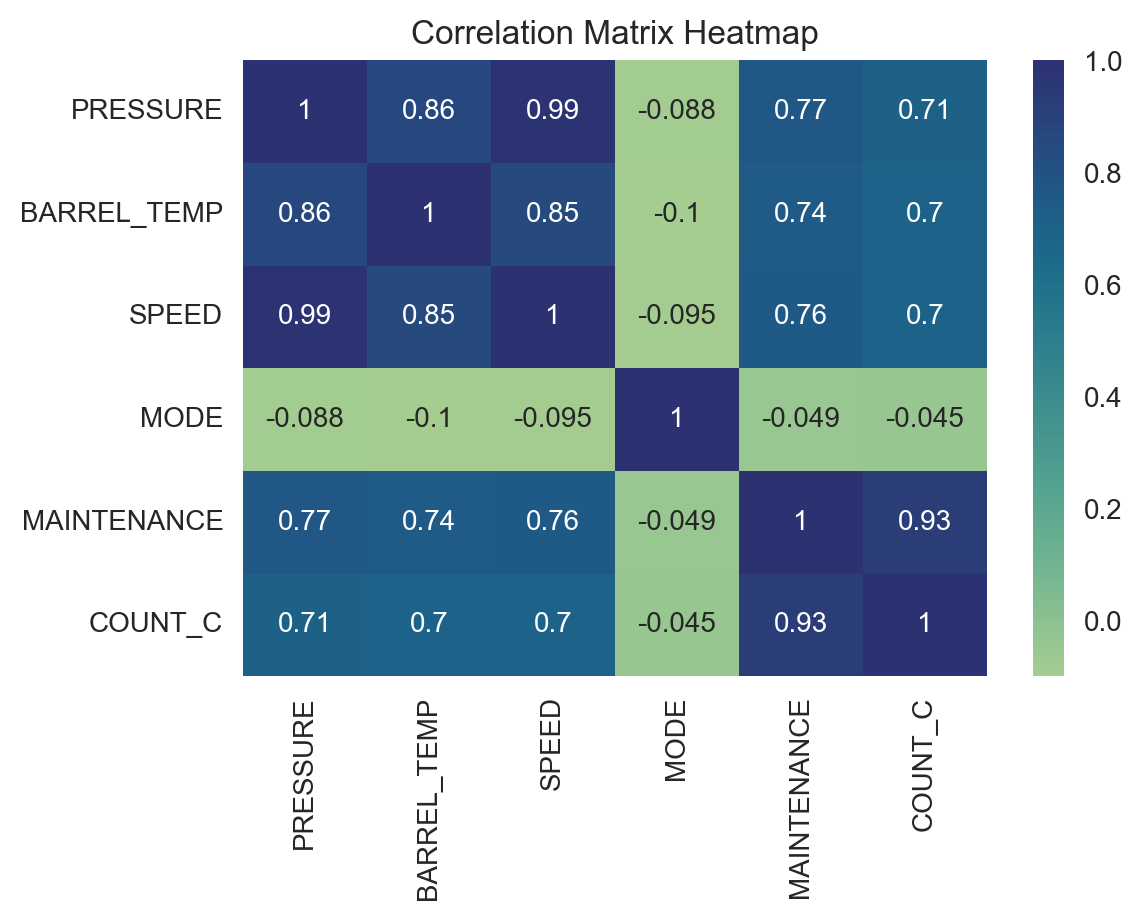

In [8]:
correlation_matrix = df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='crest')
plt.title("Correlation Matrix Heatmap")
plt.show()

### Observations

- Our target feature `Maintenance` is highly correlated with the `Count_C` descriptive feature (0.93).
- `Speed` and `Pressure` are almost colinear with a correlation coefficient of 0.99.
- `Speed` and `Barrel Temperature` are highly correlated at 0.85.
- `Barrel Temperature` and `Pressure` are also highly correlated at 0.86.
- The `Mode` feature doesn't seem to be correlated with any of the other features in the dataset.

At this point, we decide to drop the `Pressure` feature due to its extremely high correlation with `Speed`.

In [9]:
df = df.drop(columns=['PRESSURE'])

### Maintenance

Let's have a look at the `Maintenance` target feature first.

In [10]:
df['MAINTENANCE'].value_counts(normalize=True)*100

MAINTENANCE
0    66.0
1    34.0
Name: proportion, dtype: float64

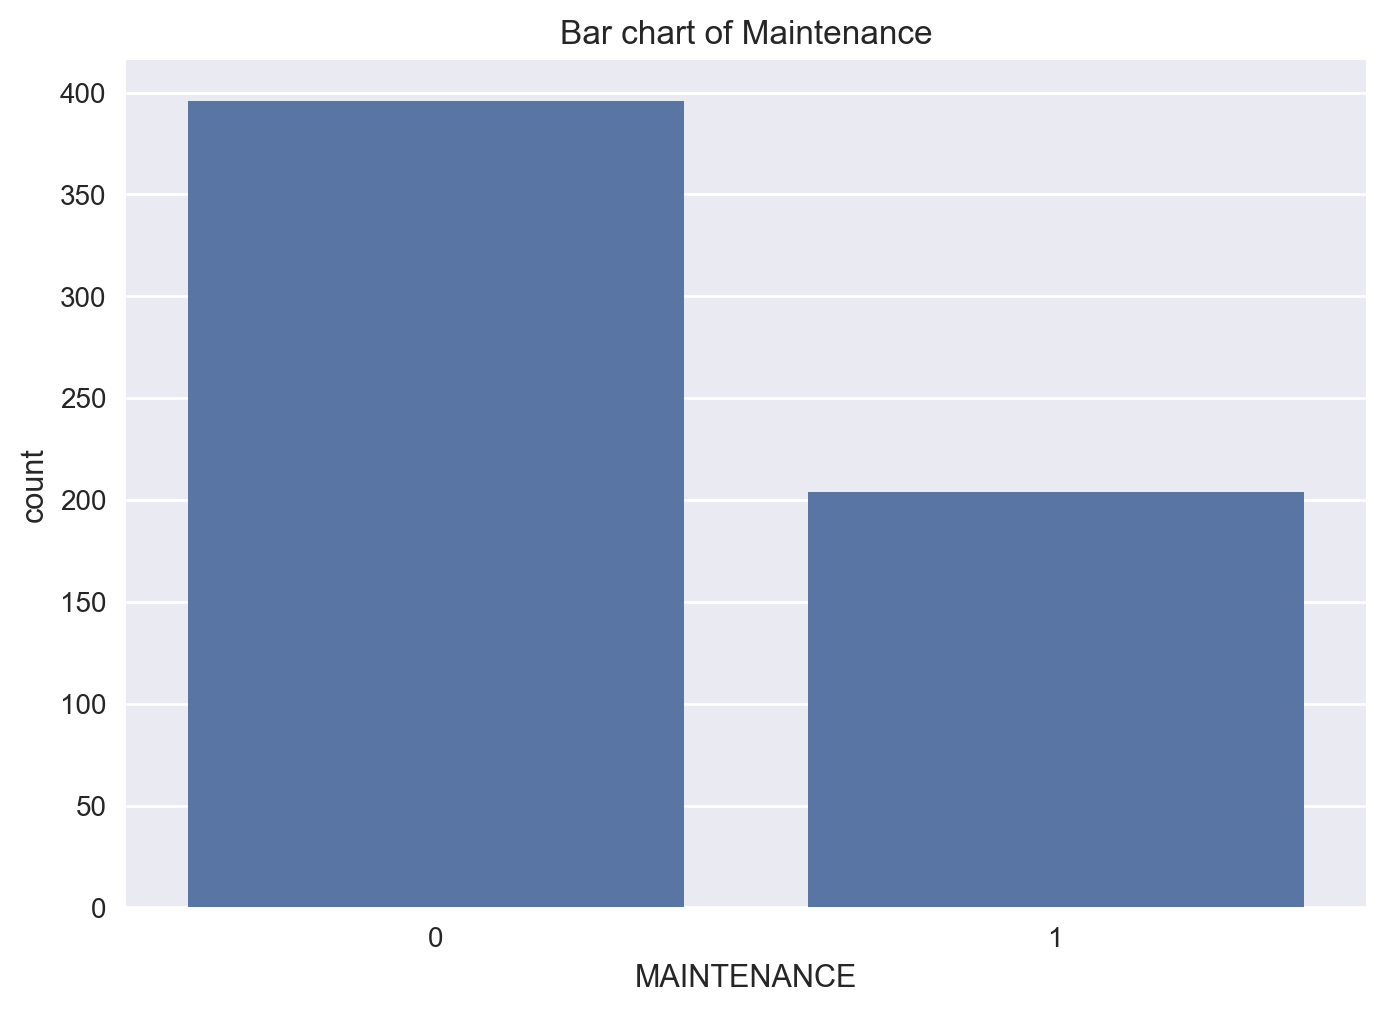

In [11]:
fig = sns.countplot(x = 'MAINTENANCE', data = df)
fig = plt.title('Bar chart of Maintenance')
plt.show()

### Mode Feature

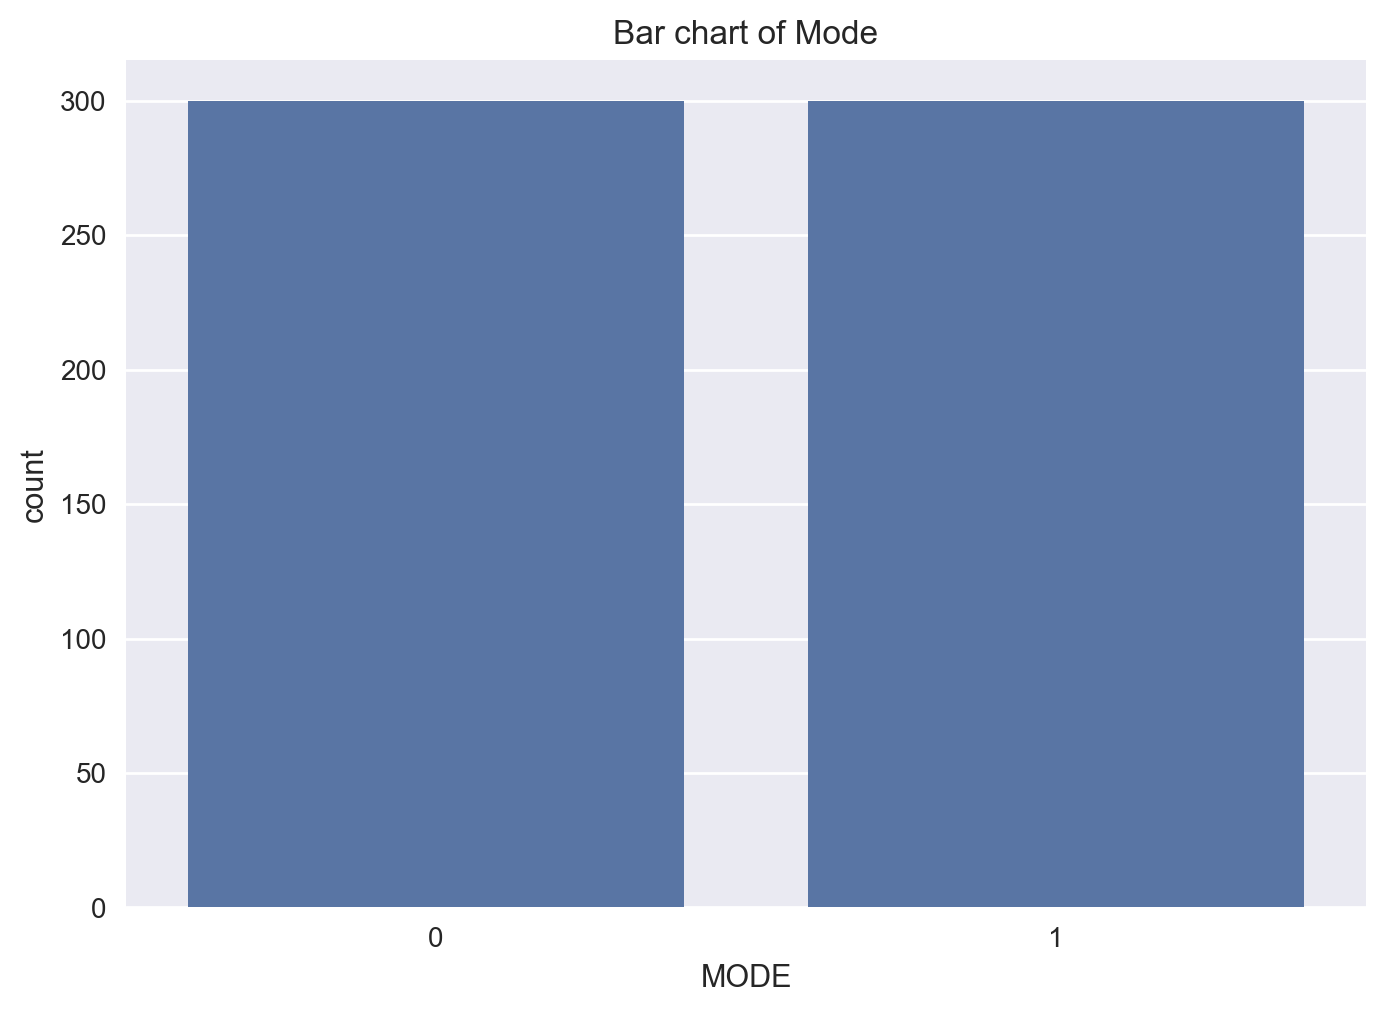

In [12]:
fig = sns.countplot(x = 'MODE', data = df)
fig = plt.title('Bar chart of Mode')
plt.show()

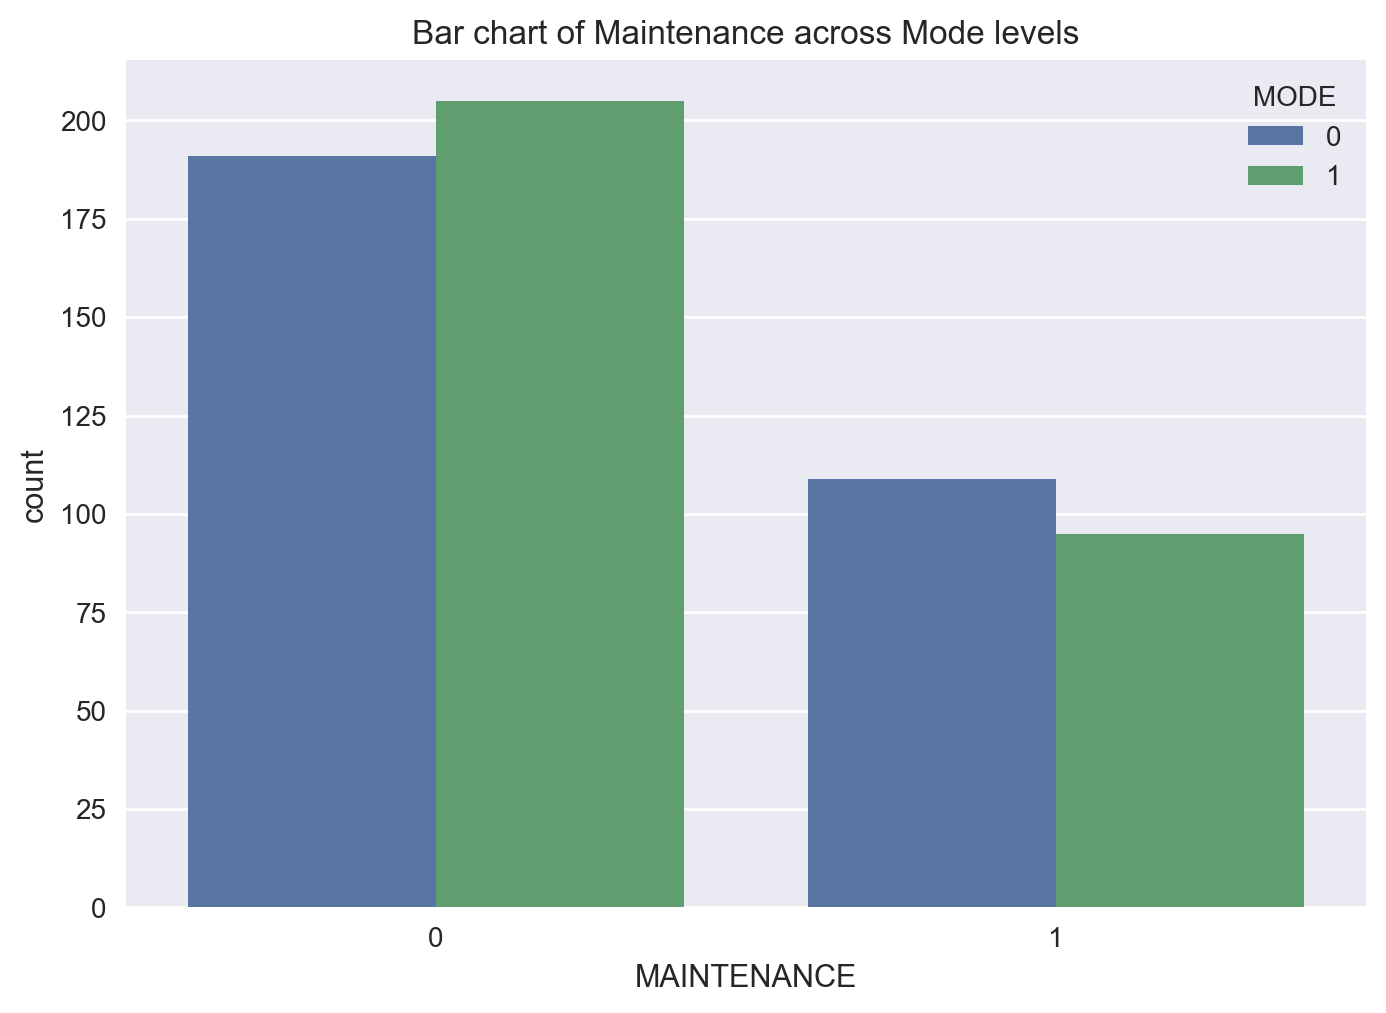

In [13]:
fig = sns.countplot(x = 'MAINTENANCE', hue='MODE', data = df)
fig = plt.title('Bar chart of Maintenance across Mode levels')
plt.show()

### Count_C Feature

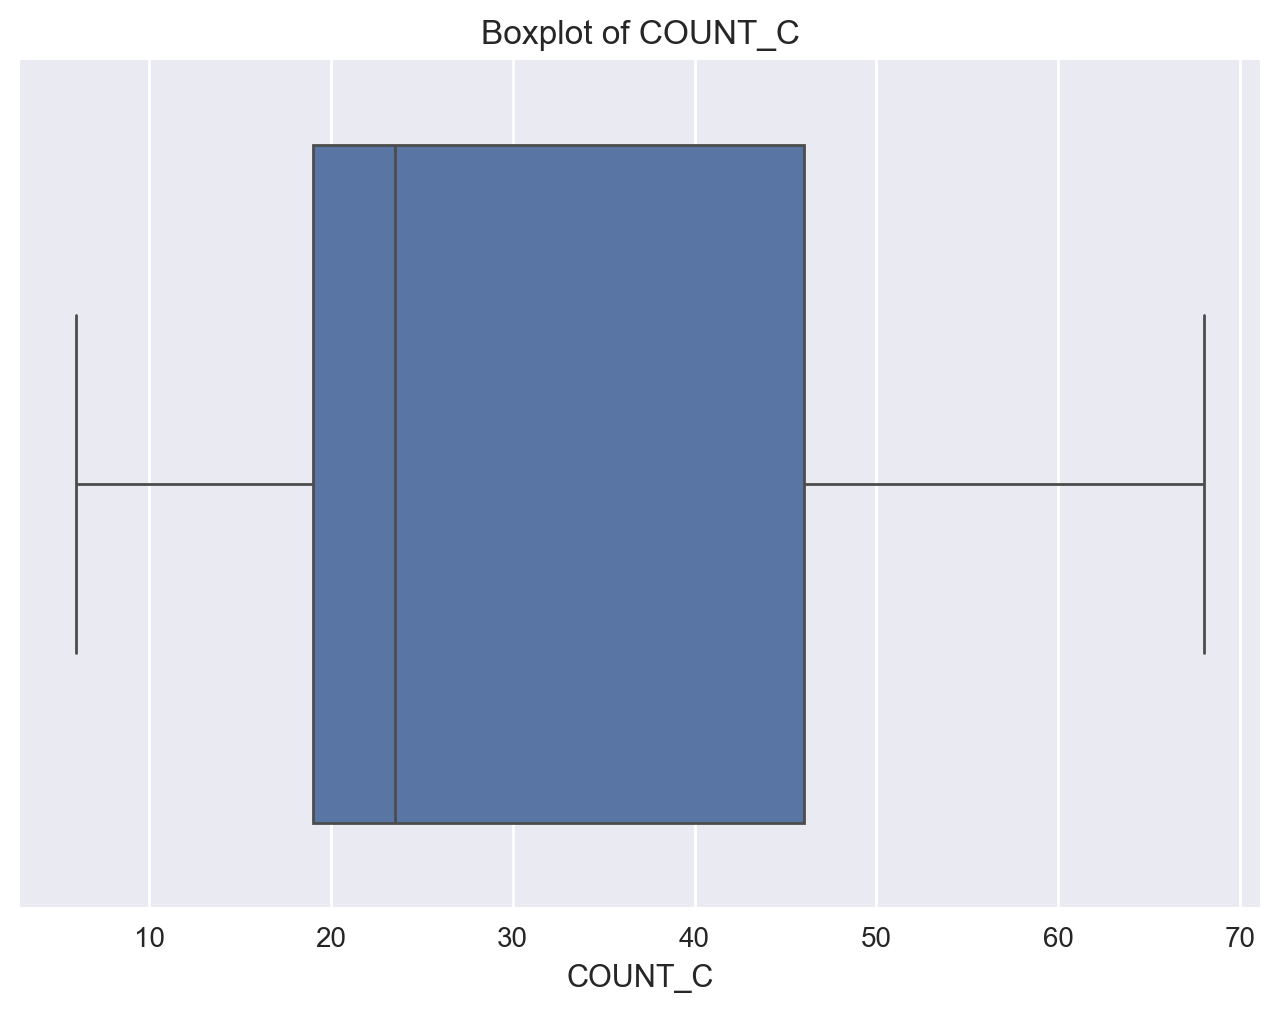

In [14]:
fig = sns.boxplot(x='COUNT_C', data=df, orient="v")
fig = plt.title('Boxplot of COUNT_C')
plt.show()

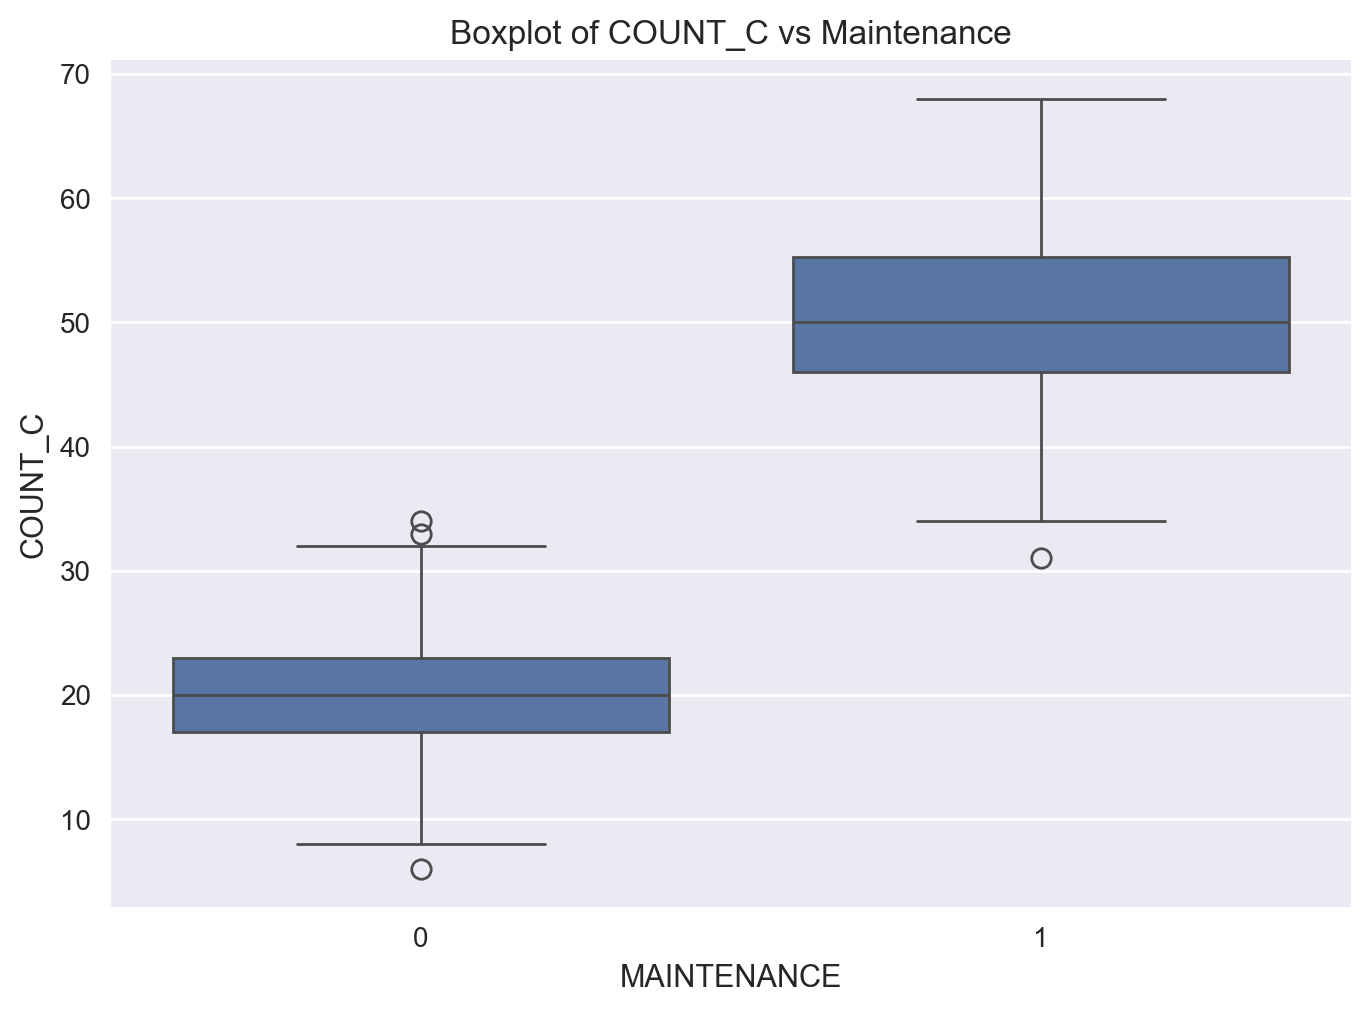

In [15]:
fig = sns.boxplot(x='MAINTENANCE', y='COUNT_C', data=df)
fig = plt.title('Boxplot of COUNT_C vs Maintenance')
plt.show()

**Observation**

We notice that there is a significant difference between Count_C values for the two levels of the Maintenance feature.

Next, let's see if Mode plays a role in this picture.

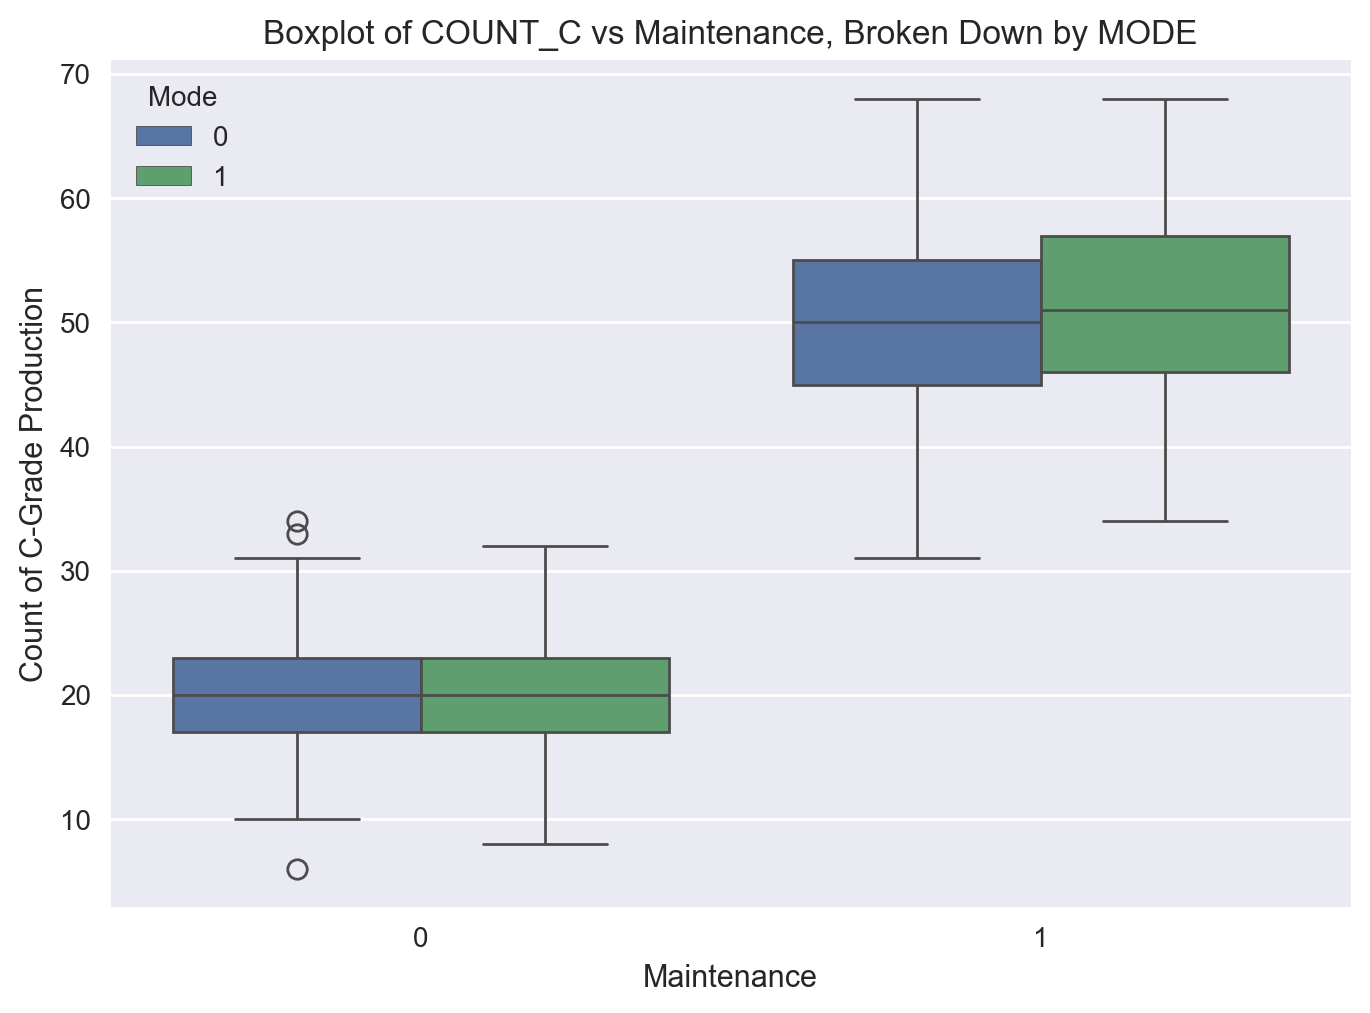

In [16]:
sns.boxplot(x='MAINTENANCE', y='COUNT_C', hue='MODE', data=df)
plt.title('Boxplot of COUNT_C vs Maintenance, Broken Down by MODE')
plt.xlabel('Maintenance')
plt.ylabel('Count of C-Grade Production')
plt.legend(title='Mode')
plt.show()


### Scatter plots

A scatter plot of Speed vs Barrel Temperature indicates a positive correlation.

A breakdown of this scatter plot across the Maintenance levels is quite revealing: majority of Maintenance occurs at high values of Speed and Barrel Temperature.

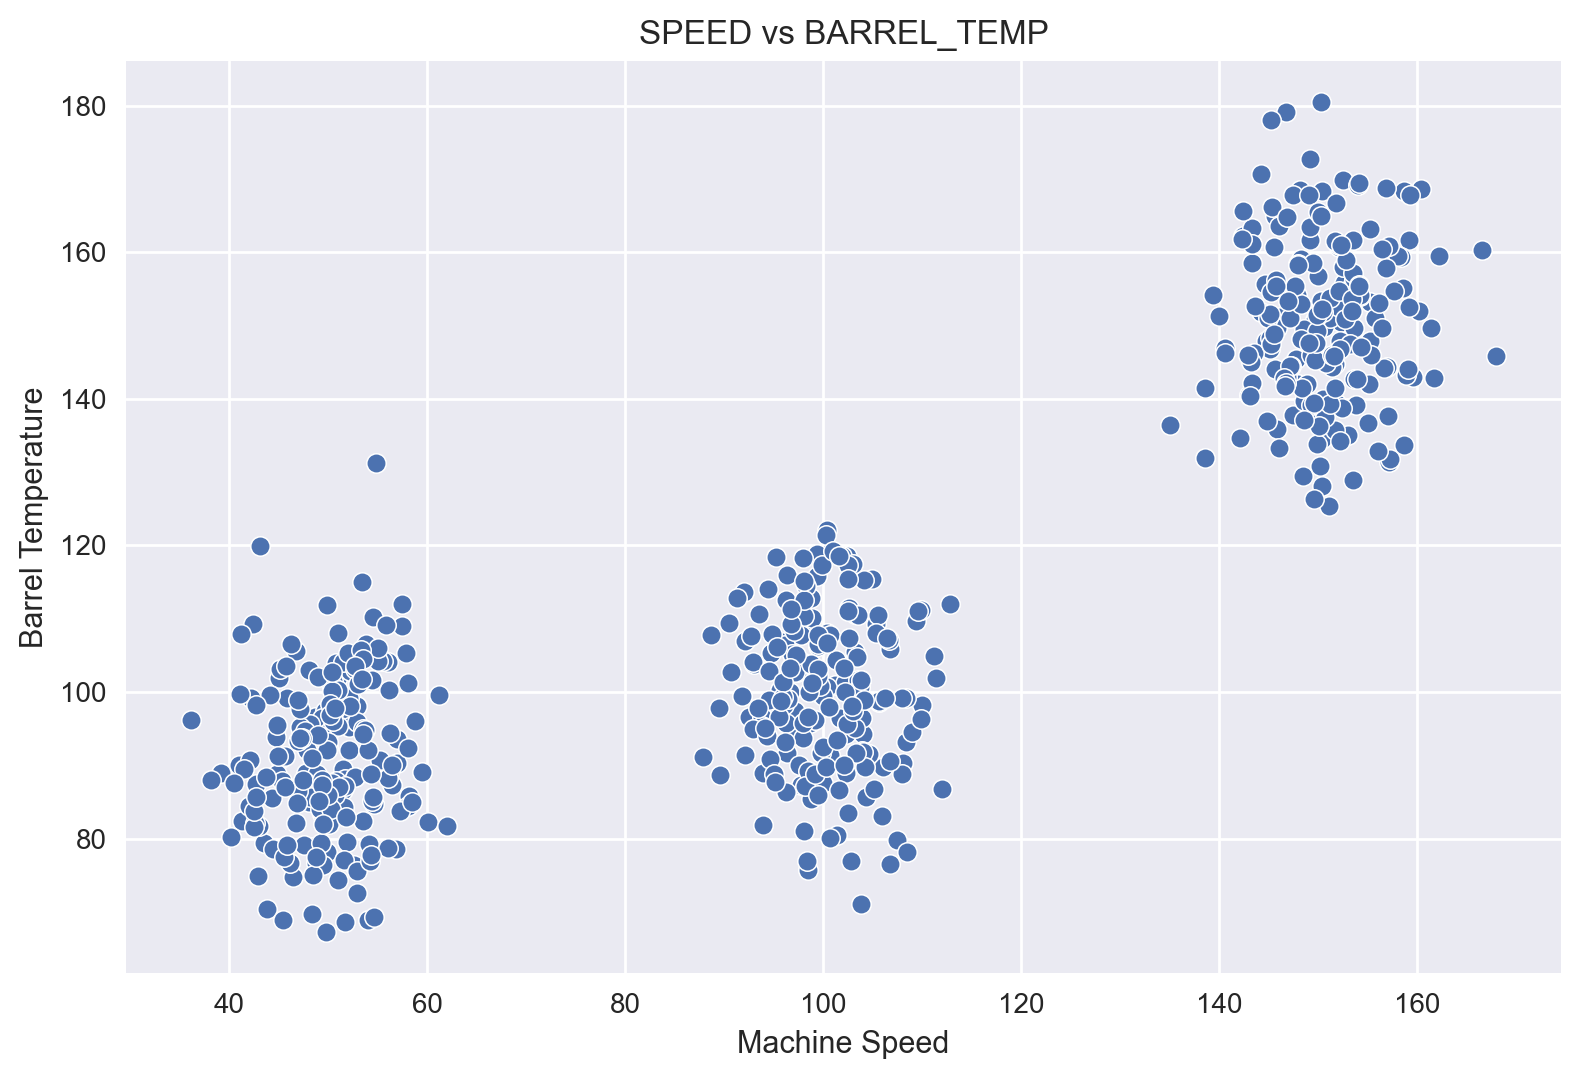

In [17]:
sns.scatterplot(x=df['SPEED'], y=df['BARREL_TEMP'])
plt.title('SPEED vs BARREL_TEMP')
plt.xlabel('Machine Speed')
plt.ylabel('Barrel Temperature')

plt.tight_layout()
plt.show()

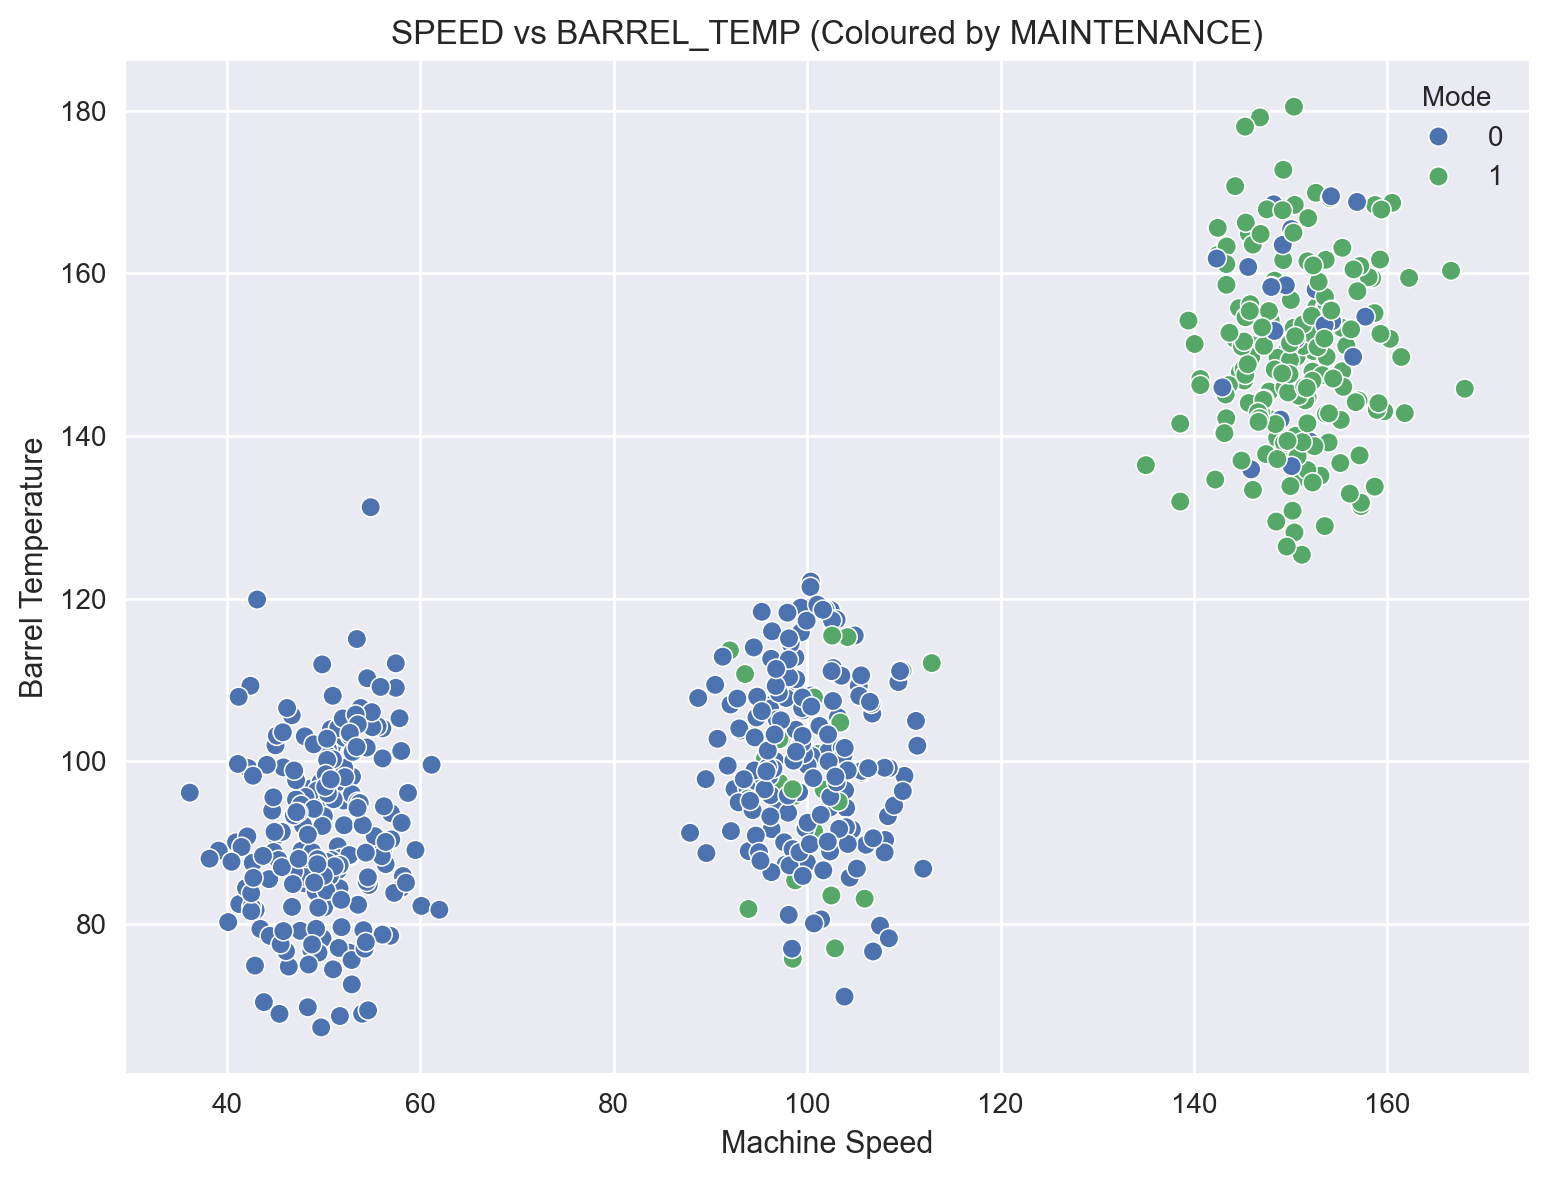

In [18]:

plt.figure(figsize=(15, 6))

# SPEED vs BARREL_TEMP with MODE
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['SPEED'], y=df['BARREL_TEMP'], hue=df['MAINTENANCE'])
plt.title('SPEED vs BARREL_TEMP (Coloured by MAINTENANCE)')
plt.xlabel('Machine Speed')
plt.ylabel('Barrel Temperature')
plt.legend(title='Mode')

plt.tight_layout()
plt.show()

## Logistic Regression <a id='lr'></a>

### Logistic Regression with All Descriptive Features

We will perform a 70/ 30 percent train/ test split.

In [19]:
print(f"{df.columns = }")

df.columns = Index(['BARREL_TEMP', 'SPEED', 'MODE', 'MAINTENANCE', 'COUNT_C'], dtype='object')


In [20]:
Data = df.drop(columns=['MAINTENANCE']).values

target = df['MAINTENANCE']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
D_train, D_test, t_train, t_test = \
    train_test_split(Data, target, test_size = 0.3, 
                     stratify=target, shuffle=True, random_state=111)

In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

In [24]:
clf.fit(D_train, t_train);

print(f"LR Test Accuracy (All Features): {clf.score(X=D_test, y=t_test):.2f}")

LR Test Accuracy (All Features): 0.99


We observe that the model is a pretty good fit with 99% accuracy.

### Logistic Regression with ONLY Count_C Feature

In [25]:
Data = df[['COUNT_C']].values

target = df['MAINTENANCE']

In [26]:
D_train, D_test, t_train, t_test = \
    train_test_split(Data, target, test_size = 0.3, 
                     stratify=target, shuffle=True, random_state=111)

In [27]:
clf.fit(D_train, t_train);

print(f"LR Test Accuracy (ONLY Count_C Feature): {clf.score(X=D_test, y=t_test):.2f}")

LR Test Accuracy (ONLY Count_C Feature): 0.99


Interestingly, we see that the LR model with ONLY the `Count_C` feature is almost as good as the previous model with all the features with 99% accuracy.

### Plotting COUNT_C vs MAINTENANCE with the logistic regression curve

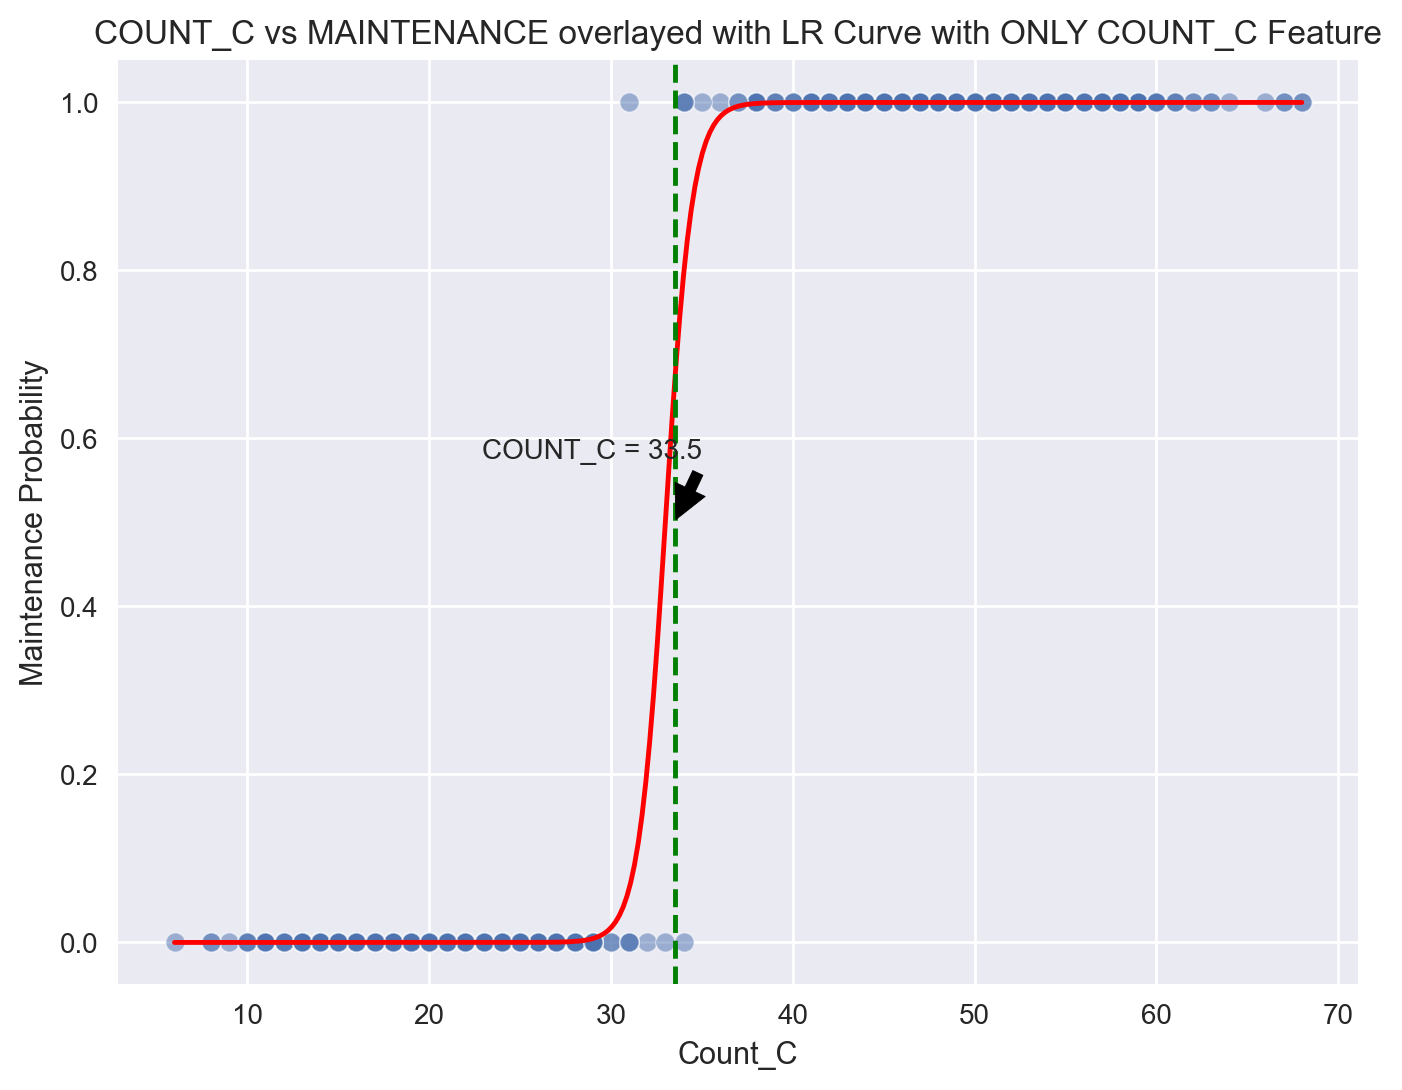

In [28]:
# data for the logistic regression curve
linspace_count_c = np.linspace(df['COUNT_C'].min(), df['COUNT_C'].max(), 300).reshape(-1,1)
probabilities = clf.predict_proba(linspace_count_c)[:, 1]

# Plot COUNT_C vs MAINTENANCE with the logistic regression curve
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['COUNT_C'], y=df['MAINTENANCE'], alpha=0.5)
plt.plot(linspace_count_c, probabilities, color='red')
plt.axvline(x=33.5, color='green', linestyle='--')

plt.annotate('COUNT_C = 33.5', xy=(33.5, 0.5), xytext=(35, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', verticalalignment='top')

plt.title('COUNT_C vs MAINTENANCE overlayed with LR Curve with ONLY COUNT_C Feature')
plt.xlabel('Count_C')
plt.ylabel('Maintenance Probability')
plt.show()

## Decision Trees <a id='dt'></a>

### Decision Tree with ONLY Count_C Feature with a Depth of 1

For simplicity, we will fit a Decision Tree with ONLY the `Count_C` feature and with a depth of 1.

I tried a full model with all the features and accuracy was about the same with 99% accuracy, so I'm not including it here in this report.

In [29]:
Data = df[['COUNT_C']].values

target = df['MAINTENANCE']

In [30]:
D_train, D_test, t_train, t_test = \
    train_test_split(Data, target, test_size = 0.3, 
                     stratify=target, shuffle=True, random_state=111)

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1, random_state = 999)

In [32]:
clf.fit(D_train, t_train);

print(f"LR Test Accuracy (ONLY Count_C Feature): {clf.score(X=D_test, y=t_test):.2f}")

LR Test Accuracy (ONLY Count_C Feature): 0.99


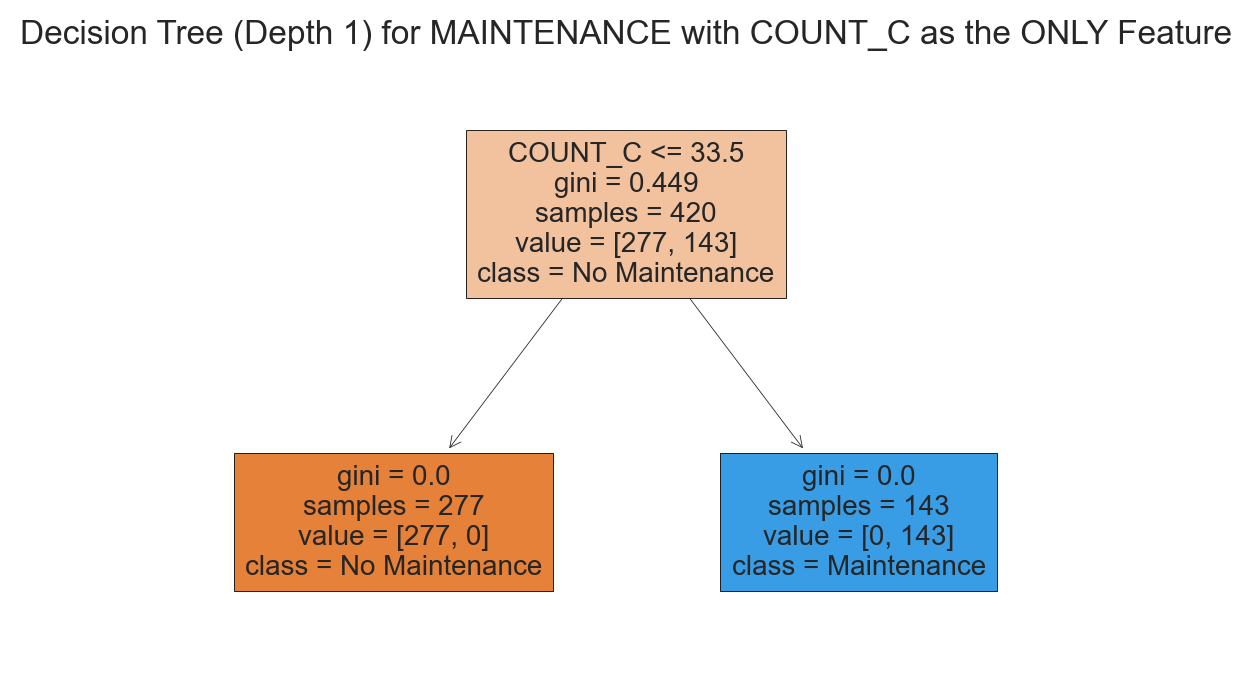

In [33]:
from sklearn import tree

plt.figure(figsize=(6, 4))
tree.plot_tree(clf, 
          filled=True, 
          feature_names=['COUNT_C'], 
          class_names=['No Maintenance', 'Maintenance'],
          fontsize=10)
plt.title("Decision Tree (Depth 1) for MAINTENANCE with COUNT_C as the ONLY Feature")
plt.show()



### Confusion Matrix

Let's work out the confusion matrix.


In [34]:
from sklearn import metrics

t_pred = clf.predict(D_test)

metrics.confusion_matrix(t_test, t_pred)

array([[118,   1],
       [  1,  60]])

### AUC Score & ROC Curve

Now, let's calculate the test AUC score. The closer to 1, the better. We shall also plot the ROC curve.

In [35]:
t_prob = clf.predict_proba(D_test)

fpr, tpr, _ = metrics.roc_curve(t_test, t_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)

print(f"AUC for DT with ONLY COUNT_C Feature: {roc_auc:.2f}")

AUC for DT with ONLY COUNT_C Feature: 0.99


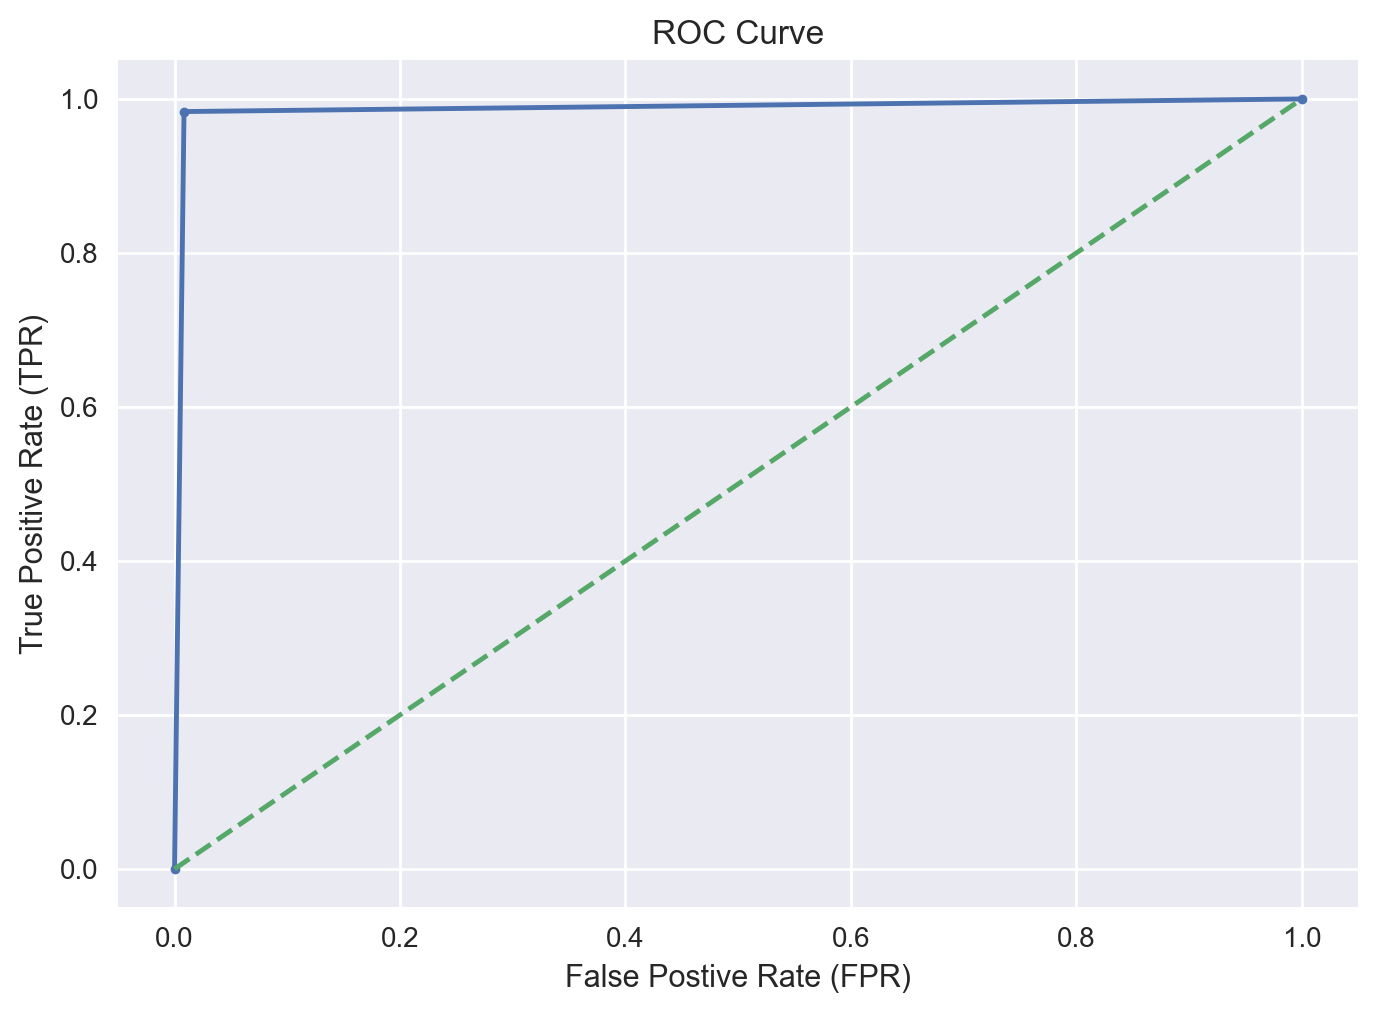

In [36]:
df_auc = pd.DataFrame({'fpr': fpr, 'tpr': tpr}) 

ax = df_auc.plot.line(x='fpr', y='tpr', title='ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show();

## Model Deployment <a id='dep'></a>

### Final Model Training

For model deployment, we will use the entire dataset for training of our final Decision Tree model.

We will save the model so that we can use it later on for making predictions in production.

In [37]:
Data = df[['COUNT_C']].values

target = df['MAINTENANCE']

clf = DecisionTreeClassifier(max_depth=1, random_state = 999)

clf.fit(D_train, t_train);

In [38]:
import joblib

joblib.dump(clf, 'DT.pkl', compress = 1)

['DT.pkl']

### Making Predictions with the DT Model

We will assume that the observation to be predicted will come as a JSON object as part of a GET endpoint call.

For simplicity, we will represent the observation as a dictionary.

Since our Decision Tree model uses only the `Count_C` feature, our dictionary will have only one key.

First, let's load back the trained model for making the actual prediction.

In [39]:
saved_dt = joblib.load('DT.pkl')

In [40]:
pred_obs = {
    "COUNT_C": 17.00
}

In [41]:
# Convert the dictionary to a 2D array
obs_array = np.array(list(pred_obs.values())).reshape(1, -1)

# Make a prediction with the saved model
prediction = saved_dt.predict(obs_array)

print(prediction)

[0]


## Summary and Conclusions <a id='summ'></a>

We observe that the `Count_C` feature seems be an excellent predictor for the `Maintenance` target feature.

A logistic regression model with all the descriptive features gives very similar results to a model with ONLY the `Count_C` feature, with both models having a test accuracy of about 99%.

Likewise, a simple decision tree with a depth of 1 also has a test accuracy of about 99% and an AUC score of 0.99.

Thus, the simple depth 1 decision tree rule below results in a 99% test accuracy:
- If `Count_C` < 33.5, then Prediction is Maintenance NOT Required.
- If `Count_C` >= 33.5, then Prediction is Maintenance IS Required.

We also present a proof-of-concept on how to train the final model for deployment and how to make predictions with the final model.

***